## Imports & Data

In [37]:
!pip install optuna boruta gdown

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import io
import time
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, precision_score
import optuna
from boruta import BorutaPy

In [39]:
try:
    df = pd.read_csv('/Users/nihalthomas/Documents/Southwest Airlines Data Science project/Southwest-Weather-Score-Project/FINAL_DATASET_CLEANED.csv')
except FileNotFoundError:
    raise FileNotFoundError("Required data file 'FINAL DATASET.csv' not found. Please check file path.")


In [40]:
# I want to see all columns when I print the dataframe to make sure this dataset is viable
pd.set_option('display.max_columns', None)
print("The dataset has", len(df), "rows.")
print(df.head())

The dataset has 4101558 rows.
   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2015        3      8           3          1  2015-08-03                WN   
1  2015        3      8           3          1  2015-08-03                WN   
2  2015        3      8           3          1  2015-08-03                WN   
3  2015        3      8           3          1  2015-08-03                WN   
4  2015        3      8           3          1  2015-08-03                WN   

   DOT_ID_Reporting_Airline  Flight_Number_Reporting_Airline  OriginAirportID  \
0                     19393                           2066.0            12896   
1                     19393                             51.0            12896   
2                     19393                             55.0            12896   
3                     19393                            714.0            12896   
4                     19393                           3740.0            12896   

  

In [41]:
total_rows = len(df)
print(f"The dataset has {total_rows} rows.\n")

# Update this list to match your new df
columns_to_check = [
    'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres',
    'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'
]

# Loop through the list
for col_name in columns_to_check:
    if col_name in df.columns:
        na_count = df[col_name].isna().sum()
        percentage = (na_count / total_rows)
        print(f"{na_count} NaN rows in {col_name} column ({percentage:.2%})")
    else:
        print(f"--- Column '{col_name}' was not found. ---")

The dataset has 4101558 rows.

0 NaN rows in tavg column (0.00%)
0 NaN rows in tmin column (0.00%)
0 NaN rows in tmax column (0.00%)
0 NaN rows in prcp column (0.00%)
0 NaN rows in snow column (0.00%)
0 NaN rows in wspd column (0.00%)
0 NaN rows in pres column (0.00%)
3318273 NaN rows in CarrierDelay column (80.90%)
3318273 NaN rows in WeatherDelay column (80.90%)
3318273 NaN rows in NASDelay column (80.90%)
3318273 NaN rows in SecurityDelay column (80.90%)
3318273 NaN rows in LateAircraftDelay column (80.90%)


### Set Target Column and Feature Columns

In [42]:
print(df.columns)

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'DOT_ID_Reporting_Airline',
       'Flight_Number_Reporting_Airline', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'Origin', 'OriginCityName',
       'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'Dest',
       'DestCityName', 'DestState', 'DestStateFips', 'DestStateName',
       'DestWac', 'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDel15',
       'DepartureDelayGroups', 'DepTimeBlk', 'CRSArrTime', 'ArrTimeBlk',
       'Cancelled', 'Diverted', 'Flights', 'Distance', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'DivAirportLandings', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd',
       'pres', 'DepHour', 'DepMinute', 'DepotalMinutes', 'DepTotalMinutes',
       'DepTime_sin', 'DepTime_cos'],
      dtype='object')


In [43]:
# 1. DEFINE YOUR BASE TARGET (the column with delay minutes)
base_delay_column = "DepDelayMinutes"  # This should be your column with delay numbers

# 2. DEFINE YOUR FEATURES
# These are the corrected names from your df.columns printout
features = [
    'Distance', 
    'tavg',      
    'tmin',      
    'tmax',
    'prcp',      
    'snow',      
    'wspd', 
    'pres',
    'DepTime_sin',
    'DepTime_cos'
]

# 3. Check for the base delay column
if base_delay_column not in df.columns:
    print(f"--- ERROR: Base delay column '{base_delay_column}' not found! ---")
else:
    print(f"Using base delay column: {base_delay_column}")
    
    # 4. CREATE YOUR NEW CLASSIFICATION TARGET
    # This is the 15-minute rule for what is 'delayed'
    df['IsDelayed'] = (df[base_delay_column] > 15).astype(int)
    
    # 5. SET THE NEW TARGET
    target = 'IsDelayed'  # <-- We are now predicting 'IsDelayed'
    print(f"New target column: {target}")

    # 6. Combine features and new target
    variables = features + [target]

    # 7. Re-create your main DataFrame
    df = df[variables].dropna().copy()
    
    # Check the balance of your new target
    print(f"\nTarget balance:\n{df[target].value_counts(normalize=True)}")
    print(f"Model data shape after dropna: {df.shape}")

Using base delay column: DepDelayMinutes
New target column: IsDelayed

Target balance:
IsDelayed
0    0.784375
1    0.215625
Name: proportion, dtype: float64
Model data shape after dropna: (4101558, 11)


# Time Series Split

In [44]:
def temporal_train_test_split(df: pd.DataFrame, test_size: float = 0.2):
    test_idx = int(len(df) * (1 - test_size))

    train_df = df.iloc[:test_idx]
    test_df = df.iloc[test_idx:]

    # Create validation set from end of training data
    val_idx = int(len(train_df) * 0.8)
    val_df = train_df.iloc[val_idx:]
    train_df = train_df.iloc[:val_idx]

    print(f"Split sizes:\n- Train: {len(train_df)}\n- Val: {len(val_df)}\n- Test: {len(test_df)}")
    return train_df, val_df, test_df

train_df, val_df, test_df = temporal_train_test_split(df)
X_train, y_train = train_df[features], train_df[target]
X_val, y_val = val_df[features], val_df[target]
X_test, y_test = test_df[features], test_df[target]

Split sizes:
- Train: 2624996
- Val: 656250
- Test: 820312


In [45]:
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import time

# --- FIX 1: Create a smaller sample for Boruta ---
# 100,000 rows is more than enough to find the important features
print("Creating a 100k row sample for Boruta...")
df_boruta_sample = train_df.sample(n=100000, random_state=42)
X_boruta = df_boruta_sample[features]
y_boruta = df_boruta_sample[target]

# --- FIX 2: Make your Random Forest faster by limiting its depth ---
rf_for_boruta = RandomForestClassifier(  # <-- Changed to Classifier
    n_jobs=-1,
    random_state=42,
    max_depth=10,
    class_weight='balanced'  # <-- Added this for your imbalanced data
)

boruta_selector = BorutaPy(
    estimator=rf_for_boruta,
    n_estimators='auto',
    max_iter=50,     # <-- Reduced iterations, will still converge
    random_state=42,
    verbose=2        # <-- Added this so you can see progress
)

# --- Fit on the SMALLER sample ---
start_time = time.time()
boruta_selector.fit(X_boruta.values, y_boruta.values)
end_time = time.time()

print(f"\nBoruta finished in {end_time - start_time:.2f} seconds.")

# --- Get your results ---
selected_mask = boruta_selector.support_
selected_features = X_boruta.columns[selected_mask].tolist()

print(f"Selected Features by Boruta ({len(selected_features)}):")
print(selected_features)

# --- Update your ORIGINAL train/val/test sets ---
print("\nUpdating X_train, X_val, and X_test with selected features...")
X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

Creating a 100k row sample for Boruta...
Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	8
Tentative: 	1
Rejected: 	1
Iteration: 	9 / 50
Confirmed: 	8
Tentative: 	1
Rejected: 	1
Iteration: 	10 / 50
Confirmed: 	8
Tentative: 	1
Rejected: 	1
Iteration: 	11 / 50
Confirmed: 	8
Tentative: 	1
Rejected: 	1
Iteration: 	12 / 50
Confirmed: 	8
Tentative: 	1
Rejected: 	1
Iteration: 	13 / 50
Confirmed: 	8
Tentative: 	1
Rejected: 	1
Iteration: 	14 / 50
Confirmed: 	8
Tentative: 	1
Rejected: 	1
Iteration: 	15 / 50
Confirmed: 	8
Tentative: 	1
Rejected: 	1
Iteration: 	16 / 50
Confirmed: 	8
Tentative: 	

# Random Forest Training Pipeline

In [46]:
# --- New, Simplified Training Pipeline ---
print("Starting classification training...")

# 1. Initialize a simple Classifier
# We use 'class_weight' because most flights are NOT delayed
rf_classifier = RandomForestClassifier(
    n_estimators=100,        # Start simple
    max_depth=10,            # A reasonable depth to prevent overfitting
    min_samples_leaf=50,     # Don't let it learn from tiny groups
    n_jobs=-1,               # Use all cores
    random_state=42,
    class_weight='balanced'  # <-- CRITICAL!
)

# 2. Train the model
start_time = time.time()
rf_classifier.fit(X_train, y_train)
print(f"Training finished in {time.time() - start_time:.2f} seconds.")

# 3. Get predictions for the Test set
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1] # Get 'Delayed' probability

# 4. Print new Classification Metrics
print("\n--- Test Set Metrics ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred):.3f}")     # <-- How many delays did we catch?
print(f"Precision: {precision_score(y_test, y_pred):.3f}")  # <-- How many of our alarms were real?
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba):.3f}") # <-- The best overall metric

Starting classification training...
Training finished in 29.84 seconds.

--- Test Set Metrics ---
Accuracy:  0.607
Recall:    0.736
Precision: 0.322
ROC-AUC:   0.708


In [47]:
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

def objective(trial):
    # 1. Define the parameters to search
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500), # Shortened for speed
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 100),
    }

    # 2. Create the classifier
    model = RandomForestClassifier(
        **params,
        n_jobs=-1,
        random_state=42,
        class_weight='balanced' # <-- Still critical
    )

    # 3. Train on a smaller sample to make tuning fast
    X_train_sample = X_train.sample(n=100000, random_state=42)
    y_train_sample = y_train.loc[X_train_sample.index]
    
    model.fit(X_train_sample, y_train_sample)

    # 4. Score it on the validation set
    # We want to maximize the ROC-AUC score
    val_preds_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, val_preds_proba)
    
    return auc

# --- Run the study ---
print("Starting Optuna study...")
# We want to MAXIMIZE the score
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20) # Run for 20 trials

print("\nBest trial:")
print(f"  Value (ROC-AUC): {study.best_value:.4f}")
print("  Params: ")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

# You can now use these best_params in your final model
best_params = study.best_params

[I 2025-11-16 16:54:41,250] A new study created in memory with name: no-name-e3174c26-48de-423e-8e54-fec675d23e82


Starting Optuna study...


[I 2025-11-16 16:54:43,025] Trial 0 finished with value: 0.7122009237800662 and parameters: {'n_estimators': 140, 'max_depth': 10, 'min_samples_leaf': 85}. Best is trial 0 with value: 0.7122009237800662.
[I 2025-11-16 16:54:47,783] Trial 1 finished with value: 0.711169713020769 and parameters: {'n_estimators': 340, 'max_depth': 14, 'min_samples_leaf': 67}. Best is trial 0 with value: 0.7122009237800662.
[I 2025-11-16 16:54:51,590] Trial 2 finished with value: 0.7126317371666632 and parameters: {'n_estimators': 357, 'max_depth': 9, 'min_samples_leaf': 81}. Best is trial 2 with value: 0.7126317371666632.
[I 2025-11-16 16:54:55,284] Trial 3 finished with value: 0.7098154363850913 and parameters: {'n_estimators': 238, 'max_depth': 14, 'min_samples_leaf': 21}. Best is trial 2 with value: 0.7126317371666632.
[I 2025-11-16 16:54:57,159] Trial 4 finished with value: 0.7120074790286239 and parameters: {'n_estimators': 233, 'max_depth': 6, 'min_samples_leaf': 99}. Best is trial 2 with value: 0.7


Best trial:
  Value (ROC-AUC): 0.7128
  Params: 
    n_estimators: 442
    max_depth: 8
    min_samples_leaf: 34


Using best params from Optuna study...
Training the final model...
Training finished in 108.82 seconds.
Generating predictions...

--- Test Set Metrics ---
Accuracy:  0.600
Recall:    0.747
Precision: 0.319
ROC-AUC:   0.707

--- Plotting Results ---


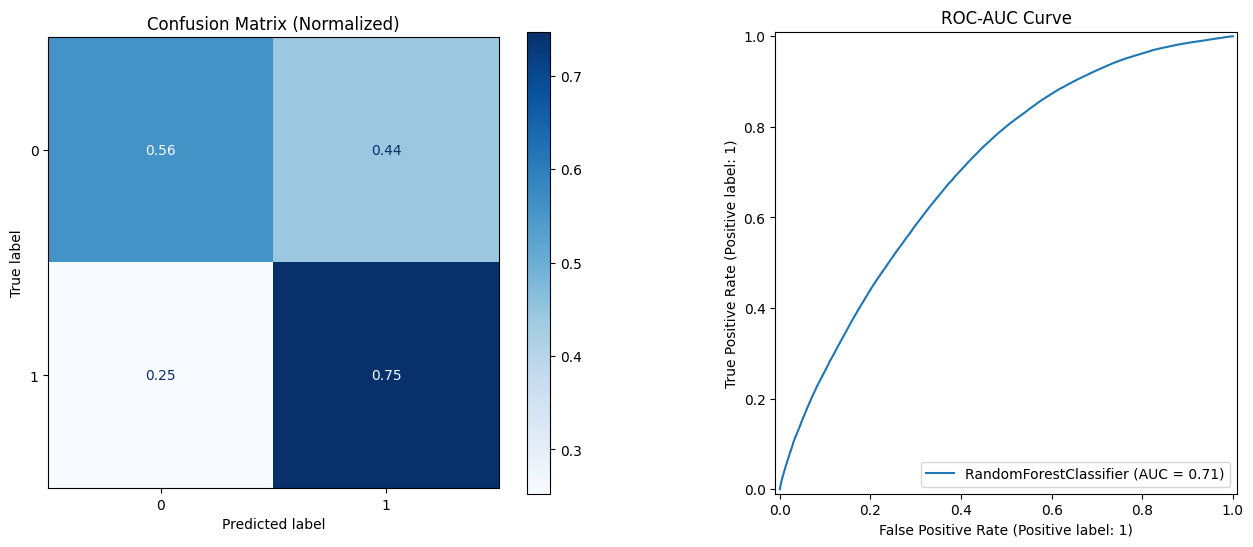

In [52]:
# --- FINAL: Train Tuned Model, Print Metrics, and Plot ---

# 1. Initialize the FINAL Tuned Classifier
print("Using best params from Optuna study...")
rf_classifier = RandomForestClassifier(
    n_estimators=442,        # <-- From Optuna
    max_depth=8,             # <-- From Optuna
    min_samples_leaf=34,     # <-- From Optuna
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'
)

# 2. Train the model
print("Training the final model...")
start_time = time.time()
rf_classifier.fit(X_train, y_train)
print(f"Training finished in {time.time() - start_time:.2f} seconds.")

# 3. Get predictions for the Test set
print("Generating predictions...")
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

# 4. Print new Classification Metrics
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score
print("\n--- Test Set Metrics ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba):.3f}")

# --- Plotting Results ---
print("\n--- Plotting Results ---")
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# 5. Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    rf_classifier,
    X_test,
    y_test,
    ax=ax[0],
    cmap='Blues',
    normalize='true'
)
ax[0].set_title('Confusion Matrix (Normalized)')

# 6. Plot ROC Curve
RocCurveDisplay.from_estimator(
    rf_classifier,
    X_test,
    y_test,
    ax=ax[1]
)
ax[1].set_title('ROC-AUC Curve')
plt.show()